## Carga de librerías

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


## Carga de datos

In [125]:
# Especificar la ruta a la carpeta que contiene los archivos CSV
ruta = os.path.abspath('../data/modelos_entrenamiento/')

# Cargar los datos desde los archivos CSV en DataFrames
X_train = pd.read_csv(os.path.join(ruta, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(ruta, 'y_train.csv'))
X_val = pd.read_csv(os.path.join(ruta, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(ruta, 'y_val.csv'))
X_test = pd.read_csv(os.path.join(ruta, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(ruta, 'y_test.csv'))

## Verificar que las dimensiones de X e y coincidan para cada conjunto de datos

In [126]:
assert X_train.shape[0] == y_train.shape[0], "Error: El número de filas en X_train y y_train no coincide."
assert X_val.shape[0] == y_val.shape[0], "Error: El número de filas en X_val y y_val no coincide."
assert X_test.shape[0] == y_test.shape[0], "Error: El número de filas en X_test y y_test no coincide."

## Separar las características (X) de la variable objetivo (y)

In [127]:
# Aquí asumimos que X_train, X_val, y X_test ya son DataFrames que contienen solo las características
# Si estos DataFrames incluyen la columna 'satisfaction', habría que eliminarla.

# Separar la variable objetivo (y)
y_train = y_train['satisfaction']
y_val = y_val['satisfaction']
y_test = y_test['satisfaction']

print("Características y etiquetas separadas correctamente.")

Características y etiquetas separadas correctamente.


## Crear el modelo y Entrenar el modelo (Entrenamiento, Validación y Prueba)

In [128]:
# Crear el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy', # si no se especifica CastBoost utilizará la log-loss como métrica de evaluación (para clasificación).
    random_seed=42, # Esto es importante cuando trabajas con entrenamiento, validación y prueba, ya que quieres asegurarte de que cualquier mejora en el rendimiento sea debido a cambios en el modelo y no a la aleatoriedad.
    verbose=100 # # Imprimir información cada 100 iteraciones
)

# Entrenar el modelo
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100,
    early_stopping_rounds=100
)



0:	learn: 0.9063646	test: 0.9076693	best: 0.9076693 (0)	total: 25ms	remaining: 12.5s
100:	learn: 0.9628676	test: 0.9571408	best: 0.9572373 (99)	total: 1.52s	remaining: 6.01s
200:	learn: 0.9676942	test: 0.9615812	best: 0.9615812 (196)	total: 2.92s	remaining: 4.35s
300:	learn: 0.9707188	test: 0.9622569	best: 0.9624982 (289)	total: 4.16s	remaining: 2.75s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9624981901
bestIteration = 289

Shrink model to first 290 iterations.


## Predicciones en cada conjunto de datos

In [129]:
# Predicciones en cada conjunto de datos
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Obtener probabilidades para el AUC
y_train_proba = model.predict_proba(X_train)[:, 1]
y_val_proba = model.predict_proba(X_val)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Métricas para el conjunto de entrenamiento
print("\n### Métricas de Entrenamiento ###")
print("ROC AUC Score en el set de entrenamiento:", roc_auc_score(y_train, y_train_proba))
print("Reporte de clasificación para entrenamiento:\n", classification_report(y_train, y_train_pred))

# Métricas para el conjunto de validación
print("\n### Métricas de Validación ###")
print("ROC AUC Score en el set de validación:", roc_auc_score(y_val, y_val_proba))
print("Reporte de clasificación para validación:\n", classification_report(y_val, y_val_pred))

# Métricas para el conjunto de prueba
print("\n### Métricas de Prueba ###")
print("ROC AUC Score en el set de prueba:", roc_auc_score(y_test, y_test_proba))
print("Reporte de clasificación para prueba:\n", classification_report(y_test, y_test_pred))


### Métricas de Entrenamiento ###
ROC AUC Score en el set de entrenamiento: 0.9970528286714175
Reporte de clasificación para entrenamiento:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     35261
           1       0.98      0.95      0.97     26895

    accuracy                           0.97     62156
   macro avg       0.97      0.97      0.97     62156
weighted avg       0.97      0.97      0.97     62156


### Métricas de Validación ###
ROC AUC Score en el set de validación: 0.9947954947691697
Reporte de clasificación para validación:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     11781
           1       0.97      0.94      0.96      8938

    accuracy                           0.96     20719
   macro avg       0.96      0.96      0.96     20719
weighted avg       0.96      0.96      0.96     20719


### Métricas de Prueba ###
ROC AUC Score en el set de prueba: 0.995051

## Matriz de confusion

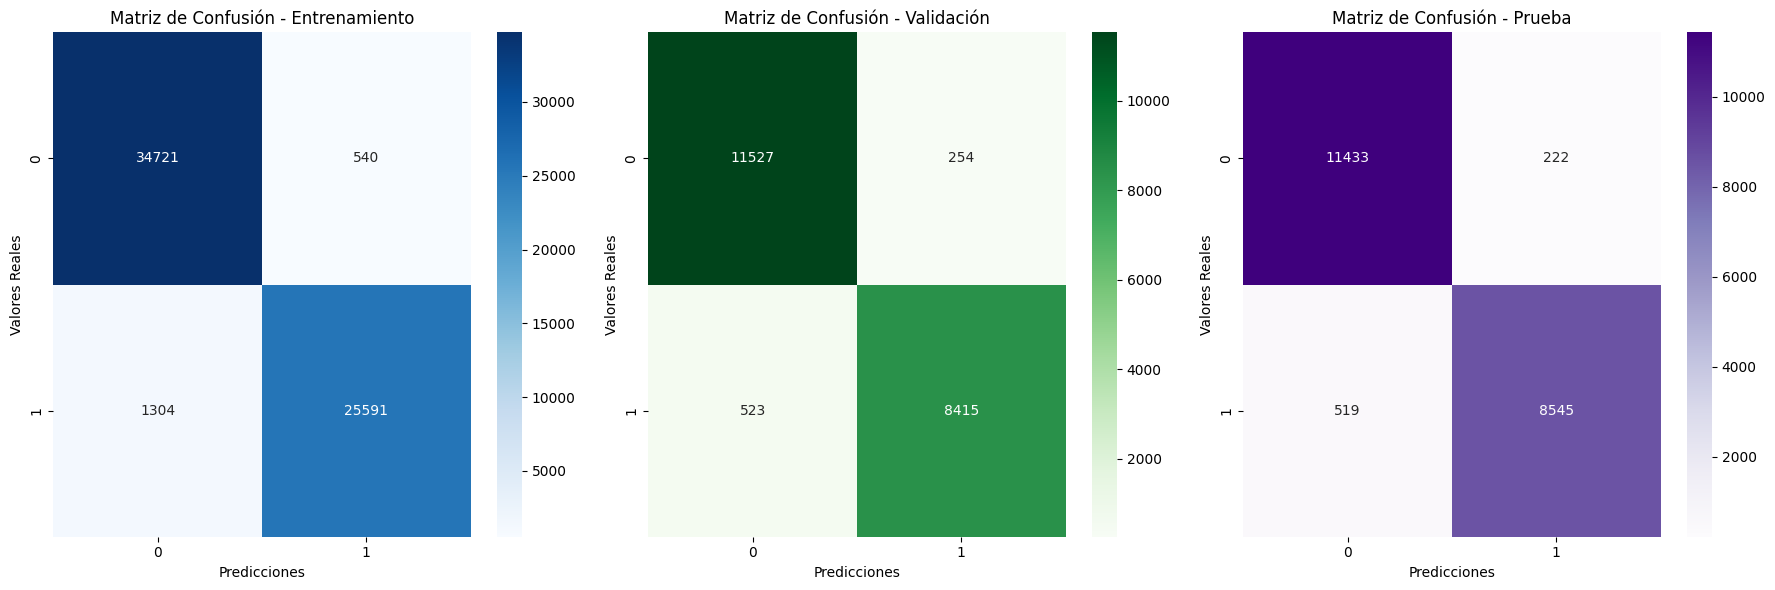

In [130]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Crear una figura con subplots para las tres matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Gráfico para la matriz de confusión de entrenamiento
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Matriz de Confusión - Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Valores Reales')

# Gráfico para la matriz de confusión de validación
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title('Matriz de Confusión - Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Valores Reales')

# Gráfico para la matriz de confusión de prueba
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Purples", ax=axes[2])
axes[2].set_title('Matriz de Confusión - Prueba')
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Valores Reales')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar la gráfica
plt.show()


**Interpretación (primer subplot: Entrenamiento):**
- 34721 (arriba a la izquierda): Verdaderos Negativos (el modelo predijo 0 y era 0).
- 25591 (abajo a la derecha): Verdaderos Positivos (el modelo predijo 1 y era 1).
- 540 (arriba a la derecha): Falsos Positivos (el modelo predijo 1, pero era 0).
- 1304 (abajo a la izquierda): Falsos Negativos (el modelo predijo 0, pero era 1).

##  Curva ROC y AUC

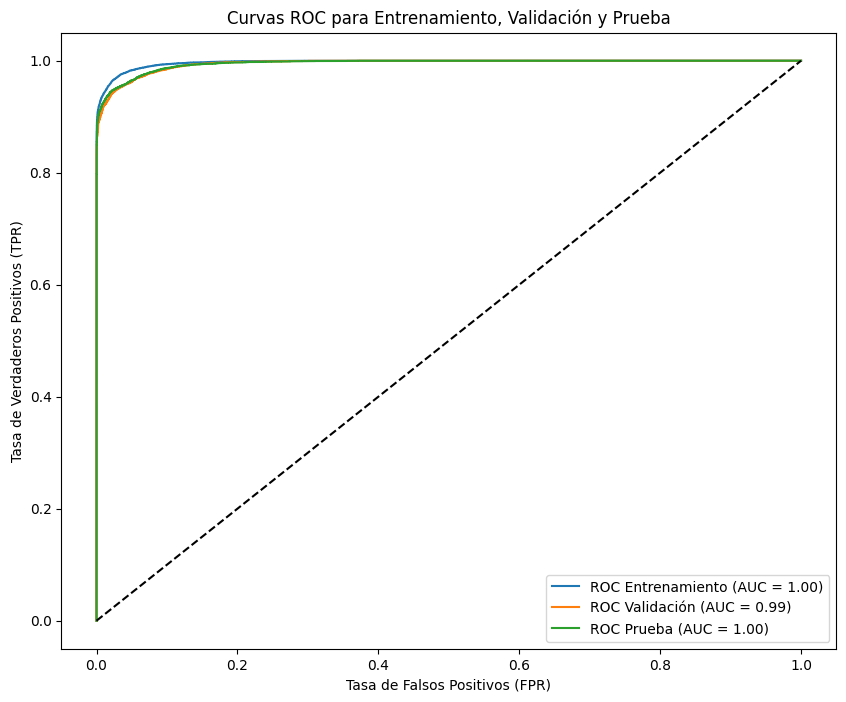

In [131]:

# Calcular los puntos de la curva ROC para cada conjunto de datos
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Calcular el AUC para cada conjunto de datos
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Visualizar las curvas ROC
plt.figure(figsize=(10, 8))

# Curva ROC para Entrenamiento
plt.plot(fpr_train, tpr_train, label=f'ROC Entrenamiento (AUC = {roc_auc_train:.2f})')

# Curva ROC para Validación
plt.plot(fpr_val, tpr_val, label=f'ROC Validación (AUC = {roc_auc_val:.2f})')

# Curva ROC para Prueba
plt.plot(fpr_test, tpr_test, label=f'ROC Prueba (AUC = {roc_auc_test:.2f})')

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--')

# Etiquetas y título
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Entrenamiento, Validación y Prueba')
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.show()


## Obtener la importancia de las características (variables)

In [132]:
# Obtener la importancia de las características
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Crear un DataFrame para visualizar la importancia
feature_importance_df = pd.DataFrame({'Característica': feature_names, 'Importancia': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df.head(10))


           Característica  Importancia
6   Inflight wifi service    26.001477
3          Type of Travel    19.491605
11        Online boarding     8.557365
1           Customer Type     7.821459
4                   Class     5.465651
17        Checkin service     4.370369
9           Gate location     3.676017
12           Seat comfort     3.534428
16       Baggage handling     3.005820
18       Inflight service     2.857705


## Visualizar la importancia de las variables

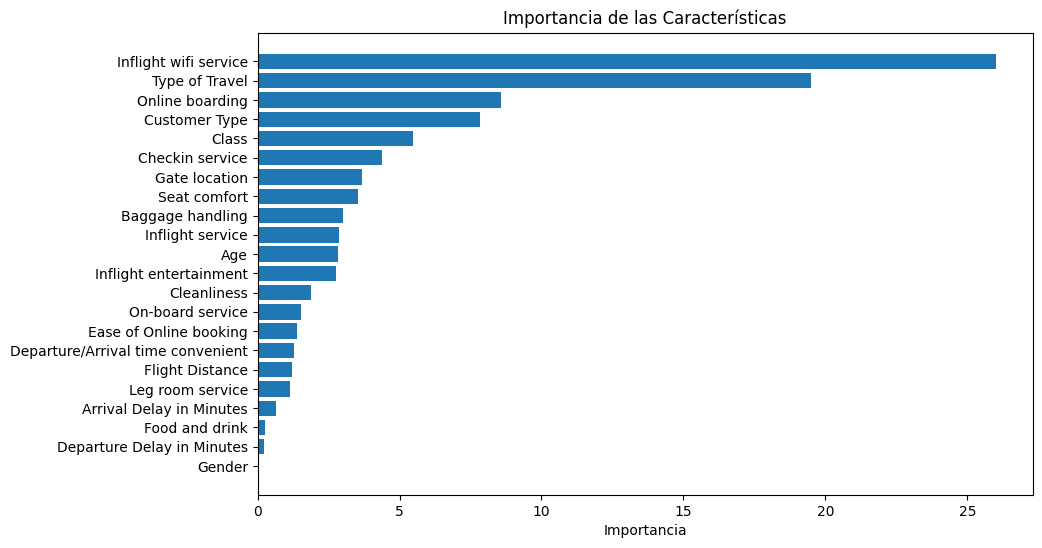

In [133]:
# Plotear la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las Características")
plt.show()


## Importancia y el impacto de las características. (SHAP summary plot)

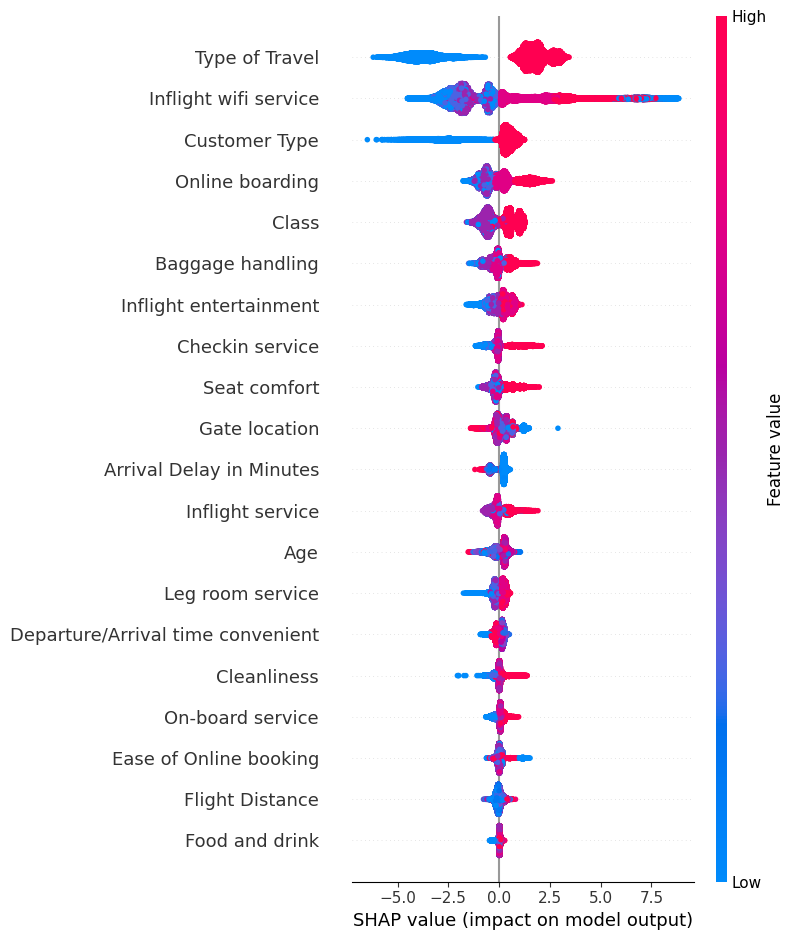

In [134]:

# Calcular los SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Plotear el resumen de los SHAP values
shap.summary_plot(shap_values, X_train)


- Type of Travel es la característica más importante y parece influir de manera significativa en si un cliente está satisfecho o no.
- Características como Inflight wifi service, Customer Type, y Online boarding también tienen un impacto notable en la predicción de satisfacción.

## Exportar modelo para ser usado en Streamlit 

In [135]:
model.save_model('../data/modelos_entrenamiento/catboost_model.cbm')

## Hacer prediciones (sin el uso de una APP) enviando el set de datos de Prueba

In [150]:
import pandas as pd
from catboost import CatBoostClassifier

# Inicializar un modelo vacío
model = CatBoostClassifier()

# Cargar el modelo desde un archivo .cbm
model.load_model('../data/modelos_entrenamiento/catboost_model.cbm')

# Usar el modelo para predecir
predicciones = model.predict(X_test)

# Convertir las predicciones a un DataFrame para facilitar la visualización
df_predicciones = pd.DataFrame(predicciones, columns=['Predicciones'])

# Si quieres agregar los valores reales también para comparación:
df_resultados = pd.DataFrame({'Valor Real': y_test, 'Predicción': predicciones})

# Imprimir el DataFrame con las predicciones
df_resultados.head()



# También puedes guardar las predicciones a un archivo CSV si es necesario
#df_resultados.to_csv('predicciones_resultados.csv', index=False)



,Valor Real,Predicción
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
